In [2]:
import os
import pandas as pd

# Containts 0.0 values: 2024-12,
# Containts no 0.0 values: 2024-08,

folder_path = os.path.join(os.getcwd(), "data", "nordic", "2024-08")
csv_files = [file for file in os.listdir(folder_path) if file.endswith('csv')]

df_frequency_merged = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df_frequency = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
    if len(df_frequency[df_frequency['Value'] < 40.0]) > 0:
        print(f"File {file} contains values below 40.0")
    # df_frequency['Value'] = df_frequency['Value'].astype(float)
    df_frequency_merged = pd.concat([df_frequency_merged, df_frequency])

# Sort the merged DataFrame by index
df_frequency_merged.sort_index(inplace=True)

# Subsample to have second instead of millisecond, not use mean
df_frequency_merged = df_frequency_merged.iloc[::10]

# Print the first few rows to verify the structure
print("\nStructure of merged_frequency_data:")
print(df_frequency_merged.head())
print("\nData types of merged_frequency_data:")
print("Time (index):", df_frequency_merged.index.dtype, "\nValue:", df_frequency_merged['Value'].dtype)




Structure of merged_frequency_data:
                        Value
Time                         
2024-08-01 00:00:00  50.00150
2024-08-01 00:00:01  49.99323
2024-08-01 00:00:02  49.98372
2024-08-01 00:00:03  49.97544
2024-08-01 00:00:04  49.96236

Data types of merged_frequency_data:
Time (index): datetime64[ns] 
Value: float64


In [3]:
df_below_40 = df_frequency_merged[df_frequency_merged["Value"] < 40.0]
print(len(df_below_40))
print(df_below_40.head())

0
Empty DataFrame
Columns: [Value]
Index: []


In [4]:
def calculate_and_print_percentage(df, lower_bound, upper_bound, description):
	percentage = (
		(df["Value"] > lower_bound) & (df["Value"] <= upper_bound)
    ).mean() * 100
	print(f"% of entries {description}: {percentage}%")

frequency_ranges = [
    (float("-inf"), 49.9, "below 49.9"),
    (50.1, float("inf"), "above 50.1"),
    (float("-inf"), 49.8, "below 49.8"),
    (50.2, float("inf"), "above 50.2"),
    (float("-inf"), 49.7, "below 49.7"),
    (50.3, float("inf"), "above 50.3"),
]

for lower_bound, upper_bound, description in frequency_ranges:
    calculate_and_print_percentage(
        df_frequency_merged, lower_bound, upper_bound, description
    )

mean_frequency = df_frequency_merged["Value"].mean()
std_dev_frequency = df_frequency_merged["Value"].std()
print(f"Number of entries: {len(df_frequency_merged)}")
print(f"Mean frequency: {mean_frequency}")
print(f"Standard Deviation of frequency: {std_dev_frequency}")
print(f"Minimum frequency: {df_frequency_merged['Value'].min()}")
print(f"Maximum frequency: {df_frequency_merged['Value'].max()}")

% of entries below 49.9: 1.0730351870836905%
% of entries above 50.1: 1.306196534512025%
% of entries below 49.8: 0.0005228670293122991%
% of entries above 50.2: 0.024126578638267518%
% of entries below 49.7: 0.0%
% of entries above 50.3: 0.00014939057980351404%
Number of entries: 2677545
Mean frequency: 50.00020458808721
Standard Deviation of frequency: 0.041216323055778874
Minimum frequency: 49.79253
Maximum frequency: 50.33846


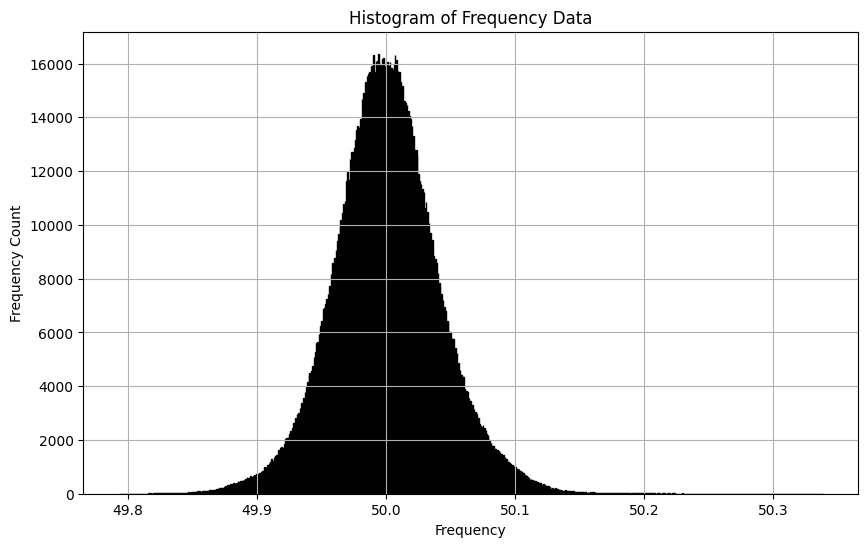

In [5]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(
    df_frequency_merged["Value"],
    bins=1000,
    color="blue",
    edgecolor="black",
)
plt.title("Histogram of Frequency Data")
plt.xlabel("Frequency")
plt.ylabel("Frequency Count")
plt.grid(True)
plt.show()

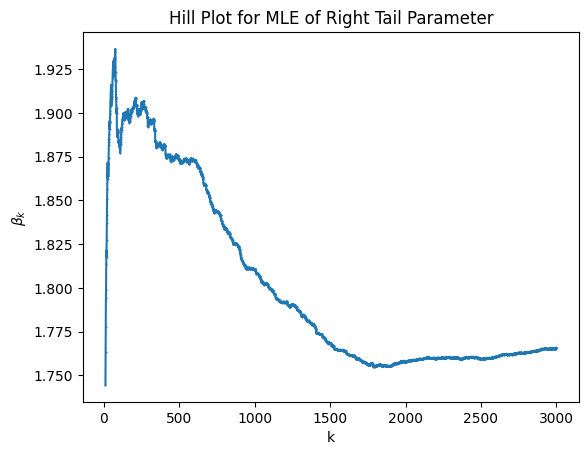

Average of beta_k values (excluding the first 20): 1.800185
Size of the dataset: 1325028


In [6]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Step 1: Select data points greater than or equal to 50.00
selected_data = df_frequency_merged[df_frequency_merged["Value"] >= 50.00]

# Step 2: Calculate differences with 50.00
deltas = selected_data["Value"] - 50.00

# Step 3: Order the deltas from large to small and index them
ordered_deltas = deltas.sort_values(ascending=False).reset_index(drop=True) + 50.00

# Step 4-7:
m_values = 3000  # Set m to a desired value
beta_values = []

for k in range(10, m_values + 1):
    # Step 5: Solve for beta using MLE
    def objective_function(beta):
        term1 = k / beta
        term2 = k * ordered_deltas[k] ** beta * np.log(ordered_deltas[k])
        term3 = np.sum(np.log(ordered_deltas[:k]))
        term4 = np.sum(ordered_deltas[:k] ** beta * np.log(ordered_deltas[:k]))
        return term1 + term2 + term3 - term4

    initial_guess = 2.0  # You can adjust the initial guess based on your data
    result = opt.least_squares(objective_function, initial_guess, method="lm")

    if result.success:
        beta_k = result.x[0]
        beta_values.append(beta_k)
    else:
        beta_values.append(np.nan)
        print(f"Failed to converge for k={k}")

# Step 7: Make Hill plot
plt.plot(range(10, m_values + 1), beta_values, marker="o", markersize=0.5)
plt.xlabel("k")
plt.ylabel(r"$\beta_k$")
plt.title("Hill Plot for MLE of Right Tail Parameter")
plt.show()

# Calculate average of beta_k values excluding the first 20 values
average_beta = np.mean(beta_values[20:])

# Print the result
print(f"Average of beta_k values (excluding the first 20): {average_beta:.6f}")
print("Size of the dataset:", len(ordered_deltas))

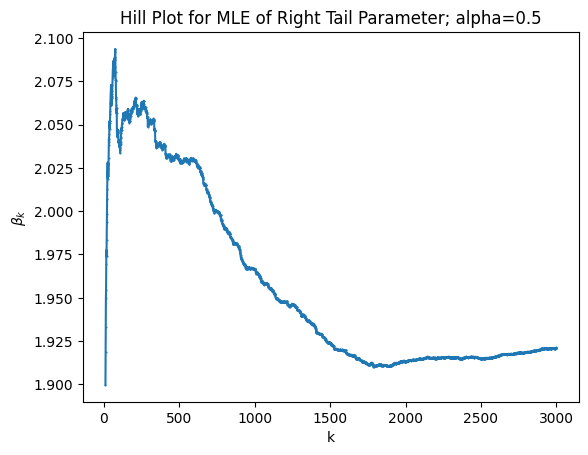

Average of beta_k values (excluding the first): 1.956207
Size of the dataset: 1325028


In [7]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Step 1: Select data points greater than or equal to 50.00
selected_data = df_frequency_merged[df_frequency_merged["Value"] >= 50.00]

# Step 2: Calculate differences with 50.00
deltas = selected_data["Value"] - 50.00

# Step 3: Order the deltas from large to small and index them
ordered_deltas = deltas.sort_values(ascending=False).reset_index(drop=True) + 50.00

# Step 4-7:
m_values = 3000  # Set m to a desired value
beta_values = []

for k in range(10, m_values + 1):
    # Step 5: Solve for beta using MLE
    def objective_function(beta):
        term1 = k / beta
        term2 = 0.5 * k * ordered_deltas[k] ** beta * np.log(ordered_deltas[k])
        term3 = np.sum(np.log(ordered_deltas[:k]))
        term4 = 0.5 * np.sum(ordered_deltas[:k] ** beta * np.log(ordered_deltas[:k]))
        return term1 + term2 + term3 - term4

    initial_guess = 2.0  # You can adjust the initial guess based on your data
    result = opt.least_squares(objective_function, initial_guess, method="lm")

    if result.success:
        beta_k = result.x[0]
        beta_values.append(beta_k)
    else:
        beta_values.append(np.nan)
        print(f"Failed to converge for k={k}")

# Step 7: Make Hill plot
plt.plot(range(10, m_values + 1), beta_values, marker="o", markersize=0.5)
plt.xlabel("k")
plt.ylabel(r"$\beta_k$")
plt.title("Hill Plot for MLE of Right Tail Parameter; alpha=0.5")
plt.show()

# Calculate average of beta_k values excluding the first 20 values
average_beta = np.mean(beta_values[1:])

# Print the result
print(f"Average of beta_k values (excluding the first): {average_beta:.6f}")
print("Size of the dataset:", len(ordered_deltas))